# Quantum Zassenhausen Algorithm

Reformulation of the Zassenhausen algorithm to work with the `QuantumClifford.jl` package by giving it a physical interpretation.

Given two subgroups of Pauli string group on N bits, $G_1 \subset P_2^N$ and $G_2 \subset P_2^N$, we would like to compute the sizes of their sum and intersection, $\langle G_1, G_2 \rangle$ and $G_1 \cap G_2$.

We need two maps:

1. $f: P_2^N \rightarrow P_2^{4N}, \quad f(g) = g \otimes g \otimes g \otimes g,$ where $\otimes$ is the Pauli string concatanation.

2. $h: P_2^N \rightarrow P_2^{4N}, \quad f(g) = g \otimes g \otimes e \otimes e,$ where $e$ is the identity of $P_2^N$.

Via which we now can define the Zassenhausen stabiliser state from these subgroups as: $$S_Z = \langle f(G_1), h(G_2) \rangle.$$

Whose entanglement measures encode what we want:

1. $ S_{vN} (S_Z, 1:4N) = 4N - \text{dim} \langle G_1, G_2 \rangle - \text{dim} G_1 \cap G_2 $

2. $ S_{vN} (S_Z, 2N+1:4N) = 2N - \text{dim} G_1 \cap G_2 $

# Zassenhausen Correlator

The anyonic two point function definition based around Pauli subgroups overlap.

The state is defined via the stabiliser group $|\Psi\rangle \equiv S_\Psi$.

The connected two-point function between two points, $r$ and $r'$, is associated with a gauge group, $G_{rr'} = \langle O_{rr'}, D \rangle$, made up from two parts. The first, $O_{rr'}$, is a representative Toric code string operator terminating at relevant points. The second is a Pauli subgroup (the noncontractable loops need not commute) of closed ribbon operator of all (in some cases not all are needed) flawours.

The idea is to check if in the state stabiliser group there is a ribbon operator connecting the two relevant points. If there is one then we declare $\langle c_r c_{r'} \rangle = \pm 1$, otherwise it is zero.

Aglebraically this can be formulated as:

$$
\langle c_r c_{r'} \rangle^2 = \text{dim} \langle O_{rr'}, D \rangle \cap S_\Psi - \text{dim} D \cap S_\Psi.
$$

The dimensions of these group intersections is computed via the Quantum Zassenhausen Algorythm, hence the dubbing.

To characterise the phase we just average this correlator over the relevant ensemble, $G(r, r') = \bar{\langle c_r c_{r'} \rangle^2}$.


# Testing the full Anyon Correlator Algorithm

Taking all the subrutines we have wrote we test them here on TC mmt induced transitions.

In [7]:
using Base.Filesystem  # for creaating directories etc
using Random, Distributions  # random numbers
using HDF5  # hdf5 files
using QuantumClifford  # this is the stabilizer simulation package
using Plots # for plotting
using Formatting # string formatting
using LinearAlgebra # some useful matrices etc.
dep_path = "../AdditionalStructure/Julia/"
include("$(dep_path)NewTypes.jl")
include("$(dep_path)BitStringOps.jl")
include("$(dep_path)Measurements.jl")
include("$(dep_path)MICModels.jl")
include("$(dep_path)ModelRuns.jl")
include("$(dep_path)HelperTools.jl")
include("$(dep_path)Iterators.jl");

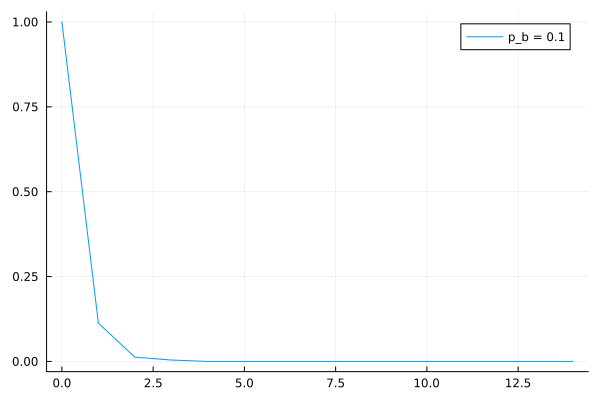

In [9]:
L = 15
d = 3

system = Init_EdgeSquareLattice_KitaevDoNuT(L, d)
t_mmt = Array{Int}(20:20:400).+50
n_t = length(t_mmt)
t_old = 0
e_deformator = get_e_deformator(system)
f_deformator = get_f_deformator(system)

all_r = []
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        push!(all_r, taxi_metrix_torus((0, 0), (x_i, y_i), L, L))
    end
end

r_max, _ = findmax(all_r)
plot_x = [0:r_max]

norm_y = zeros(Float64, r_max + 1)
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        norm_y[taxi_metrix_torus((0, 0), (x_i, y_i), L, L) + 1] += 1
    end
end

# Setup Done

scatter()

# Iteration 1

p_f = 0.0
p_b = 0.1
p_tc = 1 - p_f - p_b
stab_distro = Categorical([p_tc/2, p_tc/2, p_b, 0, p_f])
state = toric_code_GS(system)

corr_function = zeros(Float64, L, L)

for t_index in 1:n_t
    t_evol = t_mmt[t_index] - t_old
    t_old = t_mmt[t_index]
    state = iterate_measurements_only_fast!(state, system, () -> toric_code(system, stab_distro), t_evol)
    corr_function += general_zassenhausen_correlator(state, system, get_e_reprentative, e_deformator)
end

plot_y = zeros(Float64, r_max + 1)
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        plot_y[taxi_metrix_torus((0, 0), (x_i, y_i), L, L) + 1] += corr_function[i, j]/n_t
    end
end

plot!(plot_x, plot_y ./ norm_y, label = "p_b = $(p_b)")

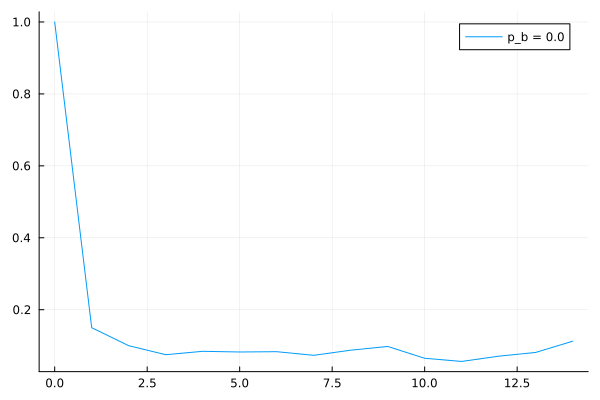

In [10]:
L = 15
d = 3

system = Init_EdgeSquareLattice_KitaevDoNuT(L, d)
t_mmt = Array{Int}(20:20:400).+50
n_t = length(t_mmt)
t_old = 0
e_deformator = get_e_deformator(system)
f_deformator = get_f_deformator(system)

all_r = []
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        push!(all_r, taxi_metrix_torus((0, 0), (x_i, y_i), L, L))
    end
end

r_max, _ = findmax(all_r)
plot_x = [0:r_max]

norm_y = zeros(Float64, r_max + 1)
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        norm_y[taxi_metrix_torus((0, 0), (x_i, y_i), L, L) + 1] += 1
    end
end

# Setup Done

scatter()

# Iteration 1

p_f = 0.5
p_b = 0.0
p_tc = 1 - p_f - p_b
stab_distro = Categorical([p_tc/2, p_tc/2, p_b, 0, p_f])
state = toric_code_GS(system)

corr_function = zeros(Float64, L, L)

for t_index in 1:n_t
    t_evol = t_mmt[t_index] - t_old
    t_old = t_mmt[t_index]
    state = iterate_measurements_only_fast!(state, system, () -> toric_code(system, stab_distro), t_evol)
    corr_function += general_zassenhausen_correlator(state, system, get_f_reprentative, f_deformator)
end

plot_y = zeros(Float64, r_max + 1)
for i = 1:L
    for j = 1:L
        x_i = i - 1
        y_i = j - 1
        plot_y[taxi_metrix_torus((0, 0), (x_i, y_i), L, L) + 1] += corr_function[i, j]/n_t
    end
end

plot!(plot_x, plot_y ./ norm_y, label = "p_b = $(p_b)")